https://medium.com/@cdabakoglu/time-series-forecasting-arima-lstm-prophet-with-python-e73a750a9887

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sklearn.metrics import mean_squared_error
from math import sqrt
warnings.filterwarnings('ignore')

In [212]:
import keras
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import TimeDistributed

# Dataset

In [213]:
df = pd.read_csv('/data/p_dsi/teams2023/team2/asurion_data/Asurion_data_iPhone_v3.csv', parse_dates=['weeks_monday','month_year'])
df

,phone_model,phone_generation,phone_size,phone_color,claim,weeks_monday,month,year,month_year
0,apple iphone 11,iphone 11,128gb,black,111,2021-06-28,6,2021,2021-06-01
1,apple iphone 11,iphone 11,128gb,black,319,2021-07-05,7,2021,2021-07-01
2,apple iphone 11,iphone 11,128gb,black,320,2021-07-12,7,2021,2021-07-01
3,apple iphone 11,iphone 11,128gb,black,305,2021-07-19,7,2021,2021-07-01
4,apple iphone 11,iphone 11,128gb,black,269,2021-07-26,7,2021,2021-07-01
...,...,...,...,...,...,...,...,...,...
17874,apple iphone xs max,iphone x,64gb,silver,18,2023-01-16,1,2023,2023-01-01
17875,apple iphone xs max,iphone x,64gb,silver,19,2023-01-23,1,2023,2023-01-01
17876,apple iphone xs max,iphone x,64gb,silver,14,2023-01-30,1,2023,2023-01-01
17877,apple iphone xs max,iphone x,64gb,silver,13,2023-02-06,2,2023,2023-02-01


In [214]:
rio_df = pd.read_csv('/data/p_dsi/teams2023/team2/asurion_data/time_series_ML_features_final.csv', parse_dates=['weeks_monday','month_year'])
rio_df

,phone_model,weeks_monday,month,year,month_year,days_since_release_date,claim
0,apple iphone 11,2021-07-05,7,2021,2021-07-01,654,2047
1,apple iphone x,2021-07-05,7,2021,2021-07-01,1340,555
2,apple iphone 11,2021-07-12,7,2021,2021-07-01,661,1900
3,apple iphone x,2021-07-12,7,2021,2021-07-01,1347,496
4,apple iphone 11,2021-07-19,7,2021,2021-07-01,668,1918
...,...,...,...,...,...,...,...
321,apple iphone 14,2023-02-06,2,2023,2023-02-01,143,61
322,apple iphone 12,2023-02-06,2,2023,2023-02-01,836,1456
323,apple iphone 13,2023-02-06,2,2023,2023-02-01,470,1191
324,apple iphone 11,2023-02-06,2,2023,2023-02-01,1235,1307


In [215]:
iphone12_df = pd.read_csv('/data/p_dsi/teams2023/team2/asurion_data/iPhone12_Final.csv', parse_dates=['weeks_monday','month_year'])
iphone12_df

,days_since_release_date,weeks_monday,month,year,month_year,holiday,this_week,avg_claim_this_month,avg_claim_last_month,1_week_ago,2_week_ago,3_week_ago,4_week_ago
0,318,2021-09-06,9,2021,2021-09-01,0,252,283.75,215.60,274.0,292.0,224.0,219.0
1,325,2021-09-13,9,2021,2021-09-01,0,266,283.75,215.60,252.0,274.0,292.0,224.0
2,332,2021-09-20,9,2021,2021-09-01,0,293,283.75,215.60,266.0,252.0,274.0,292.0
3,339,2021-09-27,9,2021,2021-09-01,0,324,283.75,215.60,293.0,266.0,252.0,274.0
4,346,2021-10-04,10,2021,2021-10-01,0,377,341.50,283.75,324.0,293.0,266.0,252.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,815,2023-01-16,1,2023,2023-01-01,0,1552,1401.60,1152.00,1558.0,1320.0,1047.0,963.0
72,822,2023-01-23,1,2023,2023-01-01,0,1407,1401.60,1152.00,1552.0,1558.0,1320.0,1047.0
73,829,2023-01-30,1,2023,2023-01-01,0,1171,1401.60,1152.00,1407.0,1552.0,1558.0,1320.0
74,836,2023-02-06,2,2023,2023-02-01,0,1456,851.00,1401.60,1171.0,1407.0,1552.0,1558.0


Text(0.5, 1.0, 'iphone 12 and days since released')

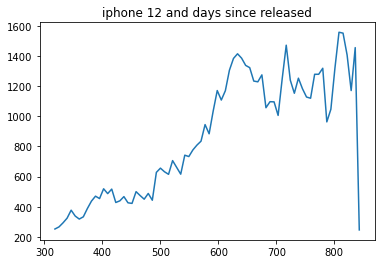

In [216]:
plt.plot(iphone12_df['days_since_release_date'], iphone12_df['this_week'])
plt.title('iphone 12 and days since released')

In [217]:
#look at where peak is for iphone 12
iphone12_df[iphone12_df['this_week'] > 1400]

,days_since_release_date,weeks_monday,month,year,month_year,holiday,this_week,avg_claim_this_month,avg_claim_last_month,1_week_ago,2_week_ago,3_week_ago,4_week_ago
45,633,2022-07-18,7,2022,2022-07-01,0,1415,1372.75,1121.0,1384.0,1306.0,1170.0,1108.0
57,717,2022-10-10,10,2022,2022-10-01,0,1472,1273.20,1064.0,1248.0,1006.0,1096.0,1097.0
70,808,2023-01-09,1,2023,2023-01-01,0,1558,1401.60,1152.0,1320.0,1047.0,963.0,1319.0
71,815,2023-01-16,1,2023,2023-01-01,0,1552,1401.60,1152.0,1558.0,1320.0,1047.0,963.0
72,822,2023-01-23,1,2023,2023-01-01,0,1407,1401.60,1152.0,1552.0,1558.0,1320.0,1047.0
74,836,2023-02-06,2,2023,2023-02-01,0,1456,851.00,1401.6,1171.0,1407.0,1552.0,1558.0


In [218]:
iphone13_df = pd.read_csv('/data/p_dsi/teams2023/team2/asurion_data/iPhone13_Final.csv', parse_dates=['weeks_monday','month_year'])
iphone13_df

,days_since_release_date,weeks_monday,month,year,month_year,holiday,this_week,avg_claim_this_month,avg_claim_last_month,1_week_ago,2_week_ago,3_week_ago,4_week_ago
0,50,2021-12-13,12,2021,2021-12-01,0,10,8.25,3.666667,2.0,6.0,3.0,2.0
1,57,2021-12-20,12,2021,2021-12-01,1,6,8.25,3.666667,10.0,2.0,6.0,3.0
2,64,2021-12-27,12,2021,2021-12-01,0,15,8.25,3.666667,6.0,10.0,2.0,6.0
3,71,2022-01-03,1,2022,2022-01-01,0,7,10.60,8.250000,15.0,6.0,10.0,2.0
4,78,2022-01-10,1,2022,2022-01-01,0,13,10.60,8.250000,7.0,15.0,6.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,449,2023-01-16,1,2023,2023-01-01,0,999,951.60,543.000000,815.0,844.0,411.0,397.0
58,456,2023-01-23,1,2023,2023-01-01,0,1191,951.60,543.000000,999.0,815.0,844.0,411.0
59,463,2023-01-30,1,2023,2023-01-01,0,909,951.60,543.000000,1191.0,999.0,815.0,844.0
60,470,2023-02-06,2,2023,2023-02-01,0,1191,707.00,951.600000,909.0,1191.0,999.0,815.0


Text(0.5, 1.0, 'iphone 13 and days since released')

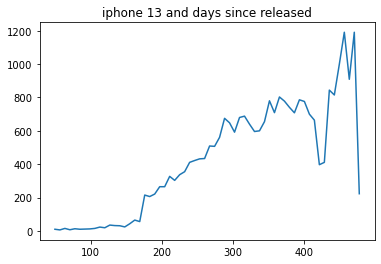

In [219]:
plt.plot(iphone13_df['days_since_release_date'], iphone13_df['this_week'])
plt.title('iphone 13 and days since released')

# ARIMA/SARIMA

### Testing SARIMA and ARIMA on different p,d,q. For SARIMA, there is a different parameter called m. 


order: a set of parameters (p, d, q) specifing the order of the autoregressive, moving average, and differencing terms.

    
**p :** The number of past observations to use or autogressive order. (If you are forecasting for week 5 and p = 2, the model would use the week 3 and 4 time series values.
    
**d :** The order of differencing. The ARIMA model works best if the time series values are not correlated. This autocorrelation can be removed by taking each observation and subtracting the previous observation. (Subtract the week 1 value from week 2, subtract week 2 from week 3 and so on to create a new time series. If the new time series is still autocorrelated, we can repeat the differencing process again.)

                                                                   
**q :** The order of the moving average term. The ARIMA model uses the error between the value the forecast model would have predicted and the actual observed value for past time series values. We use q to specify the number of past error terms to include in the model.


**m :** Number of periods in a complete seasonal cycle. (Called seasonal_periods in triple exponential smoothing)

In [220]:
# Split the data into training and testing sets (iphone 12 train is before and include first peak)
train = iphone12_df[iphone12_df['days_since_release_date'] <=717][['days_since_release_date', 'this_week']]
test = iphone12_df[iphone12_df['days_since_release_date'] >717][['days_since_release_date', 'this_week']][:-1]


**I choose the cut off as the second peak so that the model can train and the gradual increase up to the peak up and then decrease. The second peak starts at day 717 from released for iphone12**

In [221]:
train.tail(5)

,days_since_release_date,this_week
53,689,1097
54,696,1096
55,703,1006
56,710,1248
57,717,1472


### SARIMA

In [222]:
from pmdarima import auto_arima
auto_arima(train['this_week'], seasonal=True, m=15,max_p=7, max_d=5,max_q=7, max_P=4, max_D=4,max_Q=4).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   58
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -329.689
Date:                Sun, 02 Apr 2023   AIC                            663.378
Time:                        23:50:32   BIC                            667.464
Sample:                             0   HQIC                           664.966
                                 - 58                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     21.4035     10.620      2.015      0.044       0.589      42.218
sigma2      6186.7319    905.180      6.835      0.000    4412.612    7960.852
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 5.91
Prob(Q):                              0.87   Prob(JB):                         0.05
Heteroskedasticity (H):               7.49   Skew:                             0.36
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.86829D+00    |proj g|=  7.46049D-03

At iterate    5    f=  4.86818D+00    |proj g|=  4.91095D-03

At iterate   10    f=  4.86770D+00    |proj g|=  9.33424D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     17      1     0     0   1.088D-06   4.868D+00
  F =   4.8676988889854256     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


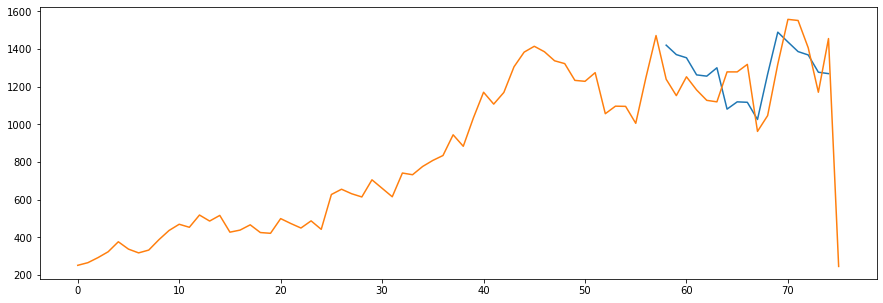

In [223]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

plt.figure(figsize=(15,5))
# define model
model = SARIMAX(train['this_week'], order=(1,0,1), seasonal_order=(0,1,0,12))

# fit model
model_fit = model.fit()

pred = model_fit.forecast(17)
plt.plot(pred)
plt.plot(iphone12_df['this_week']);



### ARIMA

In [224]:
auto_arima(train['this_week'], seasonal=False, m=15,max_p=7, max_d=5,max_q=7, max_P=4, max_D=4,max_Q=4).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   58
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -329.689
Date:                Sun, 02 Apr 2023   AIC                            663.378
Time:                        23:50:32   BIC                            667.464
Sample:                             0   HQIC                           664.966
                                 - 58                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     21.4035     10.620      2.015      0.044       0.589      42.218
sigma2      6186.7319    905.180      6.835      0.000    4412.612    7960.852
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 5.91
Prob(Q):                              0.87   Prob(JB):                         0.05
Heteroskedasticity (H):               7.49   Skew:                             0.36
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

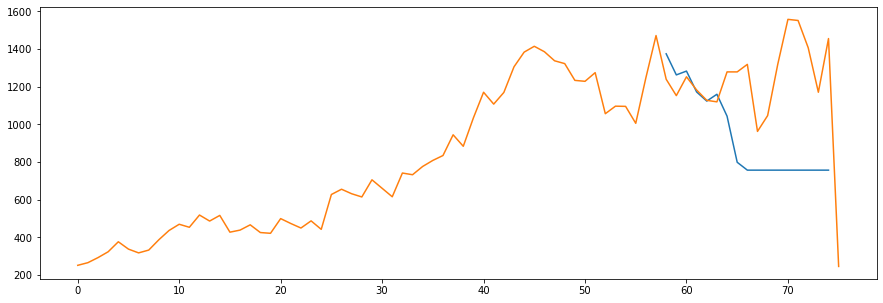

In [225]:
from statsmodels.tsa.arima.model import ARIMA

plt.figure(figsize=(15,5))
# define model
model = ARIMA(train['this_week'], order=(0,0,8))

# fit model
model_fit = model.fit()

pred = model_fit.forecast(17)
plt.plot(pred)
plt.plot(iphone12_df['this_week']);



# LSTM

### spliting and scaling data

In [226]:
df = pd.read_csv('/data/p_dsi/teams2023/team2/asurion_data/Asurion_data_iPhone_v3.csv', parse_dates=['weeks_monday','month_year'])
iphone12 = df[df['phone_generation'] == 'iphone 12']
iphone12

,phone_model,phone_generation,phone_size,phone_color,claim,weeks_monday,month,year,month_year
3027,apple iphone 12,iphone 12,128gb,black,14,2021-08-02,8,2021,2021-08-01
3028,apple iphone 12,iphone 12,128gb,black,43,2021-08-09,8,2021,2021-08-01
3029,apple iphone 12,iphone 12,128gb,black,57,2021-08-16,8,2021,2021-08-01
3030,apple iphone 12,iphone 12,128gb,black,65,2021-08-23,8,2021,2021-08-01
3031,apple iphone 12,iphone 12,128gb,black,59,2021-08-30,8,2021,2021-08-01
...,...,...,...,...,...,...,...,...,...
6241,apple iphone 12 pro max,iphone 12,512gb,silver,7,2023-01-09,1,2023,2023-01-01
6242,apple iphone 12 pro max,iphone 12,512gb,silver,9,2023-01-16,1,2023,2023-01-01
6243,apple iphone 12 pro max,iphone 12,512gb,silver,5,2023-01-23,1,2023,2023-01-01
6244,apple iphone 12 pro max,iphone 12,512gb,silver,8,2023-01-30,1,2023,2023-01-01


In [227]:
#create one hot encoding for color, and model
color_one_hot = pd.get_dummies(iphone12['phone_color'])
model_one_hot = pd.get_dummies(iphone12['phone_model'])

#added the one hot encoding in the dataframe
iphone12 = pd.concat([iphone12,color_one_hot, model_one_hot ], axis = 1)


#change storage to int and convert weeks_monday to week_of_year
iphone12['phone_size'] = iphone12['phone_size'].str.replace('gb', '').astype(int)
iphone12['weeks_monday'] = pd.to_datetime(df['weeks_monday'])
iphone12['week_of_year'] = df['weeks_monday'].apply(lambda x: x.isocalendar()[1]).astype(int)

#drop not needed columns
iphone12 = iphone12.drop(['phone_model', 'phone_generation', 'phone_color', 'weeks_monday', 'month_year'], axis=1)


iphone12

,phone_size,claim,month,year,black,blue,gold,gray,green,purple,red,silver,white,apple iphone 12,apple iphone 12 mini,apple iphone 12 pro,apple iphone 12 pro max,week_of_year
3027,128,14,8,2021,1,0,0,0,0,0,0,0,0,1,0,0,0,31
3028,128,43,8,2021,1,0,0,0,0,0,0,0,0,1,0,0,0,32
3029,128,57,8,2021,1,0,0,0,0,0,0,0,0,1,0,0,0,33
3030,128,65,8,2021,1,0,0,0,0,0,0,0,0,1,0,0,0,34
3031,128,59,8,2021,1,0,0,0,0,0,0,0,0,1,0,0,0,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6241,512,7,1,2023,0,0,0,0,0,0,0,1,0,0,0,0,1,2
6242,512,9,1,2023,0,0,0,0,0,0,0,1,0,0,0,0,1,3
6243,512,5,1,2023,0,0,0,0,0,0,0,1,0,0,0,0,1,4
6244,512,8,1,2023,0,0,0,0,0,0,0,1,0,0,0,0,1,5


In [228]:
# iphone12 = pd.concat([iphone12, size_one_hot,color_one_hot ], axis = 1)
# iphone12 = iphone12.groupby(['weeks_monday']).sum()
# iphone12 = iphone12.drop(['month', 'year'], axis=1)
# iphone12



# LSTM KERAS

In [229]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [230]:
#split into training and testing set

train = iphone12.iloc[:int(len(iphone12) * 0.75), :]
test = iphone12.iloc[int(len(iphone12) * 0.75):, :]

x_train = np.array(train.drop(['claim'], axis=1))
y_train = np.array(train['claim'])

x_test = np.array(test.drop(['claim'], axis=1))
y_test = np.array(test.drop(['claim'], axis=1))

# X_train = x_train.reshape((x_train.shape[0], 1, 30))
# X_test = x_test.reshape((x_test.shape[0], 1, 30))
# x_train= x_train.reshape(x_train.shape[0],x_train.shape[1],1)
# x_test= x_test.reshape(x_test.shape[0],x_test.shape[1],1)


Standardardize the features with StandardScaler which normalize/standardize i.e. μ = 0 and σ = 1 your features/variables/columns of X, individually, before applying any machine learning model.

In [231]:
#Identify the X and Y
X = np.array(train.drop(['claim'], axis=1))
y = np.array(train['claim'])

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

#split into testing and training set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, shuffle = True)

In [232]:
X_test

array([[-1.06907673,  0.04264571,  0.14887038, ..., -0.60894338,
        -0.21218305, -0.00908421],
       [-0.13334387,  1.16468115, -1.73266415, ...,  1.64218881,
        -0.21218305,  1.28087298],
       [ 1.73812185,  0.04264571,  0.14887038, ..., -0.60894338,
        -0.21218305,  0.11991151],
       ...,
       [-0.13334387,  0.32315457, -1.73266415, ...,  1.64218881,
        -0.21218305,  0.31340509],
       [-0.13334387, -0.51837201,  0.14887038, ..., -0.60894338,
        -0.21218305, -0.46056922],
       [ 1.73812185, -0.51837201,  0.14887038, ...,  1.64218881,
        -0.21218305, -0.58956494]])

Reshape the target and output to pass into the LSTM Model

In [233]:
#identify the number of features using our x 
n_features = X_train.shape[1]

# identify the number of samples in our training set
n_sample_train = X_train.shape[0]
n_sample_test = X_test.shape[0]

In [234]:
#reshape training
X_train_reshaped = X_train.reshape((n_sample_train, 1, n_features))
y_train_reshaped = y_train.reshape((n_sample_train, 1))

#reshape testing 
X_test_reshaped = X_test.reshape((n_sample_test, 1, n_features))
y_test_reshaped = y_test.reshape((n_sample_test, 1))

**Optimizers:** Classes or methods used to change the attributes of your machine/deep learning model such as weights and learning rate in order to reduce the losses. Optimizers help to get results faster


source: https://analyticsindiamag.com/guide-to-tensorflow-keras-optimizers/#:~:text=Optimizers%20are%20Classes%20or%20methods,help%20to%20get%20results%20faster.

In [235]:
from tensorflow.keras import layers
# define optimzer
optimizer = keras.optimizers.Adam(lr = 0.01)



### Defining the model and its layer


Timedistributed layer wraps every layer and applies it at every time step. It reshapes the inputs from batch size, input, dimmension and treat it as a separate instance.reshapes the inputs from 

**[batch size, time steps, input dimensions]** to **[batch size × time steps, input dimensions]**

In [236]:
#input and output sequences
input_sequence_len = X_train.shape[0]
out_sequence_len = y_train.shape[0]

#input and output feature dimmension
input_feature_dim = X_train.shape[1]
output_feature_dim = y_train.shape[0]


In [237]:
#LSTM unit and dropout dimmention
lstm_unit = 24
lstm_layer = 3
lstm_dropout = 0.2

In [238]:
#Model
model = Sequential()
model.add(LSTM(units=lstm_unit, activation = 'relu', input_shape = (1, input_feature_dim), 
               return_sequences=True))
model.add(LSTM(units=lstm_unit, 
               return_sequences=True))
model.add(Dense(units =1))

In [239]:
#encoder
# encoder_inputs = Inputs(shape = input_sequence_len, input_feature_dim)
# encoder_LSTM = LSTM(units=lstm_unit, activation = 'relu', input_shape = (input_feature_dim, 1), 
#                return_sequences=True, return_state= True)


In [240]:
#decoder
# decoder_LSTM = LSTM(units = lstm)

In [241]:
#combine encoder

In [136]:
# Define the LSTM model architecture
# model = Sequential()
# model.add(LSTM(units=64, activation='relu', input_shape=(n_steps, n_features)))
# model.add(Dense(units=1))

# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error')

**compile model** : Compile defines the loss function, the optimizer and the metrics.

It has nothing to do with the weights and you can compile a model as many times as you want without causing any problem to pretrained weights.

source: https://stackoverflow.com/questions/47995324/does-model-compile-initialize-all-the-weights-and-biases-in-keras-tensorflow#:~:text=What%20does%20compile%20do%3F,any%20problem%20to%20pretrained%20weights.

In [137]:
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError
# #custom function for mse at last time step in our network
# def last_time_step_mse(Y_true, Y_pred):
#     #only computes MSE over the last time step 
#     return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1]) 

# #compile the model 
# lstm_model.compile(loss ='mse', optimizer = optimizer, metrics = [last_time_step_mse])

# es_callback = keras.callbacks.EarlyStopping(monitor='val_root_mean_squared_error',
#                                                mode='min',patience=10)


In [138]:
history = model.fit(X_train_reshaped, y_train_reshaped, epochs=20, batch_size=32)

# "loss": "mean_squared_error",
# "optimizer": "adam",
# "dropout": 0.2,
# "lstm_units": 90,
# "epochs": 30,
# "batch_size": 128,
# "es_patience" : 10


Epoch 1/20
50/50 [==============================] - 3s 3ms/step - loss: 9161.3809
Epoch 2/20
50/50 [==============================] - 0s 2ms/step - loss: 7804.1362
Epoch 3/20
50/50 [==============================] - 0s 3ms/step - loss: 7018.0352
Epoch 4/20
50/50 [==============================] - 0s 2ms/step - loss: 6443.6787
Epoch 5/20
50/50 [==============================] - 0s 2ms/step - loss: 5987.8701
Epoch 6/20
50/50 [==============================] - 0s 2ms/step - loss: 5585.0664
Epoch 7/20
50/50 [==============================] - 0s 2ms/step - loss: 5237.0752
Epoch 8/20
50/50 [==============================] - 0s 2ms/step - loss: 4916.0518
Epoch 9/20
50/50 [==============================] - 0s 2ms/step - loss: 4644.0269
Epoch 10/20
50/50 [==============================] - 0s 2ms/step - loss: 4392.9438
Epoch 11/20
50/50 [==============================] - 0s 2ms/step - loss: 4160.3359
Epoch 12/20
50/50 [==============================] - 0s 2ms/step - loss: 3959.6147
Epoch 13/20
5

### Prediction Result

In [139]:
#predict on test set
predict = model.predict(X_test_reshaped)

27/27 [==============================] - 0s 1ms/step


In [140]:
#get array of outputs from predicted set
test_result = [i[0][0] for i in predict]

***Mean Absolute Percentage Error (MAPE)***

The Mean Absolute Percentage Error (MAPE) is a common metric for measuring error in forecasts. The MAPE represents error as a percentage of the actual observed values. A high MAPE value means the error is large relative to the quantity being measuring and so the forecast is poor. A small MAPE means the error is relatively small so the forecast is good.

The MAPE is given by:

$$ MAPE = \frac{1}{n} \sum_{i=1}^{n} \frac{|F_t - A_t|}{A_t} $$

where $A_t$ is the actual observed value, $F_t$ is the forecast, and $n$ is the number of data points the MAPE is being calculated over. Read about MAPE at https://en.wikipedia.org/wiki/Mean_absolute_percentage_error


**The function returns the MAPE as decimal rounded to 5 decimal places (i.e. MAPE = 0.10325)**


In [141]:
def get_mape(actuals, forecasts):
    MAPE = np.sum(np.abs(forecasts - actuals)/actuals)/len(forecasts)
    return MAPE

In [142]:
predicted_MAPE= get_mape(y_test,test_result )
predicted_MAPE

0.8613958305665081

***Wmape***

In [143]:
def wmape(actual, forecast):
    # we take two series and calculate an output a wmape from it, not to be used in a grouping function
    # make a series called mape
    se_mape = abs(actual-forecast)/actual
    # get a float of the sum of the actual
    ft_actual_sum = actual.sum()
    # get a series of the multiple of the actual & the mape
    se_actual_prod_mape = actual * se_mape
    # summate the prod of the actual and the mape
    ft_actual_prod_mape_sum = se_actual_prod_mape.sum()
    # float: wmape of forecast
    ft_wmape_forecast = ft_actual_prod_mape_sum / ft_actual_sum
    # return a float
    return ft_wmape_forecast

In [144]:
predicted_WMAPE = wmape(y_test,test_result)
predicted_WMAPE

0.3064554216678634

In [245]:
test_copy = test
test


,phone_size,claim,month,year,black,blue,gold,gray,green,purple,red,silver,white,apple iphone 12,apple iphone 12 mini,apple iphone 12 pro,apple iphone 12 pro max,week_of_year
5441,128,135,11,2021,0,0,1,0,0,0,0,0,0,0,0,0,1,47
5442,128,172,11,2021,0,0,1,0,0,0,0,0,0,0,0,0,1,48
5443,128,162,12,2021,0,0,1,0,0,0,0,0,0,0,0,0,1,49
5444,128,168,12,2021,0,0,1,0,0,0,0,0,0,0,0,0,1,50
5445,128,118,12,2021,0,0,1,0,0,0,0,0,0,0,0,0,1,51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6241,512,7,1,2023,0,0,0,0,0,0,0,1,0,0,0,0,1,2
6242,512,9,1,2023,0,0,0,0,0,0,0,1,0,0,0,0,1,3
6243,512,5,1,2023,0,0,0,0,0,0,0,1,0,0,0,0,1,4
6244,512,8,1,2023,0,0,0,0,0,0,0,1,0,0,0,0,1,5


In [ ]:
test[['phone_size', 'claim', 'month', 'year', 'black', 'week_of_year']]

In [146]:
iphone12_base = test[test['apple iphone 12 pro max'] == 1]
iphone12_base

,phone_size,claim,month,year,black,blue,gold,gray,green,purple,red,silver,white,apple iphone 12,apple iphone 12 mini,apple iphone 12 pro,apple iphone 12 pro max,week_of_year
5441,128,135,11,2021,0,0,1,0,0,0,0,0,0,0,0,0,1,47
5442,128,172,11,2021,0,0,1,0,0,0,0,0,0,0,0,0,1,48
5443,128,162,12,2021,0,0,1,0,0,0,0,0,0,0,0,0,1,49
5444,128,168,12,2021,0,0,1,0,0,0,0,0,0,0,0,0,1,50
5445,128,118,12,2021,0,0,1,0,0,0,0,0,0,0,0,0,1,51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6241,512,7,1,2023,0,0,0,0,0,0,0,1,0,0,0,0,1,2
6242,512,9,1,2023,0,0,0,0,0,0,0,1,0,0,0,0,1,3
6243,512,5,1,2023,0,0,0,0,0,0,0,1,0,0,0,0,1,4
6244,512,8,1,2023,0,0,0,0,0,0,0,1,0,0,0,0,1,5


In [256]:
test[['black','blue', 'gold', 'gray',
       'green', 'purple', 'red', 'silver', 'white']].sum()

black       0
blue      154
gold      199
gray      222
green       0
purple      0
red         0
silver    230
white       0
dtype: int64

In [248]:
test.columns

Index(['phone_size', 'claim', 'month', 'year', 'black', 'blue', 'gold', 'gray',
       'green', 'purple', 'red', 'silver', 'white', 'apple iphone 12',
       'apple iphone 12 mini', 'apple iphone 12 pro',
       'apple iphone 12 pro max', 'week_of_year'],
      dtype='object')

# LSTM TRAINED ON 12, Validate 13, and Predict 14

Let's retrain on all iphone 12

## Train

In [275]:
#Define Train, Test, and Validate a
train = iphone12[['phone_size', 'claim', 'month', 'year', 'gray', 'gold','week_of_year']]

#Identify the X and Y
x_train = np.array(train.drop(['claim'], axis=1))
y_train = np.array(train['claim'])

# Standardize the features
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)

#identify the number of features using our x 
n_features = x_train.shape[1]

# identify the number of samples in our training set
n_sample_train = x_train.shape[0]

#reshape training
X_train_reshaped = x_train.reshape((n_sample_train, 1, n_features))
y_train_reshaped = y_train.reshape((n_sample_train, 1))

In [302]:
#input and output sequences
input_sequence_len = X_train.shape[0]
out_sequence_len = y_train.shape[0]

#input and output feature dimmension
input_feature_dim = x_train.shape[1]
output_feature_dim = y_train.shape[0]

In [303]:
input_feature_dim

6

## Validate

In [304]:
df[df['phone_generation'] == 'iphone 13']

,phone_model,phone_generation,phone_size,phone_color,claim,weeks_monday,month,year,month_year
6246,apple iphone 13,iphone 13,128gb,blue,2,2021-11-29,11,2021,2021-11-01
6247,apple iphone 13,iphone 13,128gb,blue,2,2021-12-13,12,2021,2021-12-01
6248,apple iphone 13,iphone 13,128gb,blue,1,2021-12-20,12,2021,2021-12-01
6249,apple iphone 13,iphone 13,128gb,blue,9,2021-12-27,12,2021,2021-12-01
6250,apple iphone 13,iphone 13,128gb,blue,3,2022-01-03,1,2022,2022-01-01
...,...,...,...,...,...,...,...,...,...
7902,apple iphone 13 pro max,iphone 13,512gb,silver,1,2023-01-16,1,2023,2023-01-01
7903,apple iphone 13 pro max,iphone 13,512gb,silver,2,2023-01-23,1,2023,2023-01-01
7904,apple iphone 13 pro max,iphone 13,512gb,silver,8,2023-01-30,1,2023,2023-01-01
7905,apple iphone 13 pro max,iphone 13,512gb,silver,14,2023-02-06,2,2023,2023-02-01


In [305]:
#Validate with one shot and rehape
validate = df[df['phone_generation'] == 'iphone 13']
v_color_one_hot = pd.get_dummies(validate['phone_color'])
v_model_one_hot = pd.get_dummies(validate['phone_model'])

#added the one hot encoding in the dataframe
validate = pd.concat([validate,v_color_one_hot, v_model_one_hot ], axis = 1)



#change storage to int and convert weeks_monday to week_of_year
validate['phone_size'] = validate['phone_size'].str.replace('gb', '').astype(int)
validate['weeks_monday'] = pd.to_datetime(validate['weeks_monday'])
validate['week_of_year'] = validate['weeks_monday'].apply(lambda x: x.isocalendar()[1]).astype(int)

#drop not needed columns
validate = validate.drop(['phone_model', 'phone_generation', 'phone_color', 'weeks_monday', 'month_year'], axis=1)
validate = validate[['phone_size', 'claim', 'month', 'year', 'green', 'blue', 'week_of_year']]

validate

,phone_size,claim,month,year,green,blue,week_of_year
6246,128,2,11,2021,0,1,48
6247,128,2,12,2021,0,1,50
6248,128,1,12,2021,0,1,51
6249,128,9,12,2021,0,1,52
6250,128,3,1,2022,0,1,1
...,...,...,...,...,...,...,...
7902,512,1,1,2023,0,0,3
7903,512,2,1,2023,0,0,4
7904,512,8,1,2023,0,0,5
7905,512,14,2,2023,0,0,6


In [306]:
#Identify the X and Y
x_validate = np.array(validate.drop(['claim'], axis=1))
y_validate = np.array(validate['claim'])

# Standardize the features
scaler = StandardScaler()
x_validate = scaler.fit_transform(x_validate)

#identify the number of features using our x 
n_features = x_validate.shape[1]

# identify the number of samples in our training set
n_sample_validate = x_validate.shape[0]

#reshape training
X_validate_reshaped = x_validate.reshape((n_sample_validate, 1, n_features))
y_validate_reshaped = y_validate.reshape((n_sample_validate, 1))

## Test

In [307]:
test[['black','blue','gold', 'purple', 'red', 'silver', 'white']].sum()

KeyError: "['blue', 'gold', 'purple', 'red', 'silver'] not in index"

In [308]:
#test with one shot and reshape 
test = df[df['phone_generation'] == 'iphone 14']


#Validate with one shot and rehape
t_color_one_hot = pd.get_dummies(test['phone_color'])
t_model_one_hot = pd.get_dummies(test['phone_model'])

#added the one hot encoding in the dataframe
test = pd.concat([test,t_color_one_hot, t_model_one_hot ], axis = 1)


#change storage to int and convert weeks_monday to week_of_year
test['phone_size'] = test['phone_size'].str.replace('gb', '').astype(int)
test['weeks_monday'] = pd.to_datetime(test['weeks_monday'])
test['week_of_year'] = test['weeks_monday'].apply(lambda x: x.isocalendar()[1]).astype(int)

#drop not needed columns
test = test.drop(['phone_model', 'phone_generation', 'phone_color', 'weeks_monday', 'month_year'], axis=1)
test = test[['phone_size', 'claim', 'month', 'year', 'black', 'white', 'week_of_year']]

test

,phone_size,claim,month,year,black,white,week_of_year
7907,128,7,11,2022,1,0,46
7908,128,11,11,2022,1,0,47
7909,128,15,11,2022,1,0,48
7910,128,25,12,2022,1,0,49
7911,128,20,12,2022,1,0,50
...,...,...,...,...,...,...,...
7970,128,50,2,2023,0,0,6
7971,128,18,2,2023,0,0,7
7972,128,68,2,2023,0,0,6
7973,128,24,2,2023,0,0,7


In [309]:
#Identify the X and Y
x_test = np.array(test.drop(['claim'], axis=1))
y_test = np.array(test['claim'])

# Standardize the features
scaler = StandardScaler()
x_test = scaler.fit_transform(x_test)

#identify the number of features using our x 
n_features = x_test.shape[1]

# identify the number of samples in our training set
n_sample_test = x_test.shape[0]

#reshape training
X_test_reshaped = x_test.reshape((n_sample_test, 1, n_features))
y_test_reshaped = y_test.reshape((n_sample_test, 1))

In [310]:
optimizer = keras.optimizers.Adam(lr = 0.01)

In [311]:
#LSTM unit and dropout dimmention
lstm_unit = 24
lstm_layer = 3
lstm_dropout = 0.2

#Model
model = Sequential()
model.add(LSTM(units=lstm_unit, activation = 'relu', input_shape = (1, input_feature_dim), 
               return_sequences=True))
model.add(LSTM(units=lstm_unit, 
               return_sequences=True))
model.add(Dense(units =1))

In [312]:
input_feature_dim

6

In [313]:
X_train_reshaped.shape

(3219, 1, 6)

In [314]:
# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error')

history = model.fit(X_train_reshaped, y_train_reshaped, epochs=20, batch_size=32)

Epoch 1/20
101/101 [==============================] - 3s 3ms/step - loss: 11727.0098
Epoch 2/20
101/101 [==============================] - 0s 3ms/step - loss: 9502.8955
Epoch 3/20
101/101 [==============================] - 0s 2ms/step - loss: 8556.0215
Epoch 4/20
101/101 [==============================] - 0s 2ms/step - loss: 8116.2920
Epoch 5/20
101/101 [==============================] - 0s 2ms/step - loss: 7872.3130
Epoch 6/20
101/101 [==============================] - 0s 2ms/step - loss: 7706.7510
Epoch 7/20
101/101 [==============================] - 0s 2ms/step - loss: 7653.8853
Epoch 8/20
101/101 [==============================] - 0s 2ms/step - loss: 7624.6367
Epoch 9/20
101/101 [==============================] - 0s 2ms/step - loss: 7613.1787
Epoch 10/20
101/101 [==============================] - 0s 2ms/step - loss: 7608.5117
Epoch 11/20
101/101 [==============================] - 0s 2ms/step - loss: 7607.1748
Epoch 12/20
101/101 [==============================] - 0s 2ms/step - loss

In [315]:
X_train_reshaped.shape

(3219, 1, 6)

In [316]:
X_test_reshaped.shape

(68, 1, 6)

#### Validate Prediction on 13

In [317]:
predict = model.predict(X_validate_reshaped)


52/52 [==============================] - 1s 1ms/step


In [318]:
#get array of outputs from predicted set
validate_result = [i[0][0] for i in predict]

predicted_MAPE= wmape(y_validate,validate_result )
predicted_MAPE

0.8389681327289108

#### Validate Prediction on 14

In [319]:
predict = model.predict(X_test_reshaped)

3/3 [==============================] - 0s 2ms/step


In [321]:
#get array of outputs from predicted set
test_result = [i[0][0] for i in predict]

predicted_MAPE= wmape(y_test,test_result )
predicted_MAPE

5.404450862085657